In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult
import math
import seaborn as sns
import matplotlib.dates as mdates
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/artifacts/df_last_year_20250109.csv")
df.head()

,datetime,symbol,price,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,circulating_supply,total_supply,date
0,2025-01-09 00:38:38,WAI,0.020860,1.020250e+06,0.0000,7.788221,12.335881,12.335881,12.335881,12.335881,12.335881,0.000000e+00,0.0000,2.086005e+07,0.000000e+00,1.000000e+09,2022-02-24
1,2025-01-09 00:38:38,ADA,0.924652,1.939491e+09,-6.0118,-2.424521,-8.537684,1.392174,-16.965305,110.523816,175.285419,3.250260e+10,0.9853,4.160936e+10,3.515115e+10,4.499512e+10,2022-02-24
2,2025-01-09 00:38:38,AVAX,37.299335,7.347442e+08,7.7448,-0.934974,-7.285825,1.592909,-23.843868,28.784312,46.534919,1.531036e+10,0.4641,2.669695e+10,4.104728e+08,4.488091e+08,2022-02-24
3,2025-01-09 00:38:38,BNB,691.104599,2.295891e+09,1.4070,-0.271765,-1.152902,-1.939567,-3.938155,12.218398,23.680743,9.952353e+10,3.0170,9.952353e+10,1.440065e+08,1.440065e+08,2022-02-24
4,2025-01-09 00:38:38,BTC,94469.951290,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,1.980741e+07,1.980741e+07,2022-02-24


In [3]:
df["symbol"].value_counts()

symbol
WAI          1041
ADA          1041
AVAX         1041
BNB          1041
BTC          1041
ETH          1041
SEAL         1041
MATIC        1041
DOGEVERSE    1041
XRP          1041
LINK         1041
SOL          1041
USDT         1041
Name: count, dtype: int64

In [4]:
df_btc = df[df["symbol"] == "BTC"]
df_btc = df_btc.drop(columns=["datetime", "symbol"])
df_btc = df_btc.reset_index(drop=True) 
df_btc = df_btc.rename(columns={'date': 'ds', 'price': 'y'})  
columns = ['ds'] + [col for col in df_btc.columns if col != 'ds']
df_btc = df_btc[columns]

df_btc.head()


,ds,y,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,circulating_supply,total_supply
0,2022-02-24,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0
1,2022-02-25,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0
2,2022-02-26,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0
3,2022-02-27,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0
4,2022-02-28,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0


In [5]:
df_btc.tail(10)

,ds,y,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,circulating_supply,total_supply
1031,2024-12-30,93821.335346,6.458813e+10,20.6081,-0.780698,-3.443075,-0.111162,-3.862244,23.077771,57.587235,1.858355e+12,56.9535,1.970248e+12,19807378.0,19807378.0
1032,2024-12-31,93821.335346,6.458813e+10,20.6081,-0.780698,-3.443075,-0.111162,-3.862244,23.077771,57.587235,1.858355e+12,56.9535,1.970248e+12,19807378.0,19807378.0
1033,2025-01-01,93821.335346,6.458813e+10,20.6081,-0.780698,-3.443075,-0.111162,-3.862244,23.077771,57.587235,1.858355e+12,56.9535,1.970248e+12,19807378.0,19807378.0
1034,2025-01-02,93822.475106,6.457933e+10,20.8796,-0.831876,-3.428913,-0.142860,-3.914102,23.123302,57.587297,1.858377e+12,56.9542,1.970272e+12,19807378.0,19807378.0
1035,2025-01-03,93822.475106,6.457933e+10,20.8796,-0.831876,-3.428913,-0.142860,-3.914102,23.123302,57.587297,1.858377e+12,56.9542,1.970272e+12,19807378.0,19807378.0
1036,2025-01-04,93822.475106,6.457933e+10,20.8796,-0.831876,-3.428913,-0.142860,-3.914102,23.123302,57.587297,1.858377e+12,56.9542,1.970272e+12,19807378.0,19807378.0
1037,2025-01-05,93822.475106,6.457933e+10,20.8796,-0.831876,-3.428913,-0.142860,-3.914102,23.123302,57.587297,1.858377e+12,56.9542,1.970272e+12,19807378.0,19807378.0
1038,2025-01-06,93822.475106,6.457933e+10,20.8796,-0.831876,-3.428913,-0.142860,-3.914102,23.123302,57.587297,1.858377e+12,56.9542,1.970272e+12,19807378.0,19807378.0
1039,2025-01-07,93822.475106,6.457933e+10,20.8796,-0.831876,-3.428913,-0.142860,-3.914102,23.123302,57.587297,1.858377e+12,56.9542,1.970272e+12,19807378.0,19807378.0
1040,2025-01-08,93822.475106,6.457933e+10,20.8796,-0.831876,-3.428913,-0.142860,-3.914102,23.123302,57.587297,1.858377e+12,56.9542,1.970272e+12,19807378.0,19807378.0


In [39]:
from prophet import Prophet # type: ignore
from datetime import timedelta

10:47:10 - cmdstanpy - INFO - Chain [1] start processing
10:47:11 - cmdstanpy - INFO - Chain [1] done processing


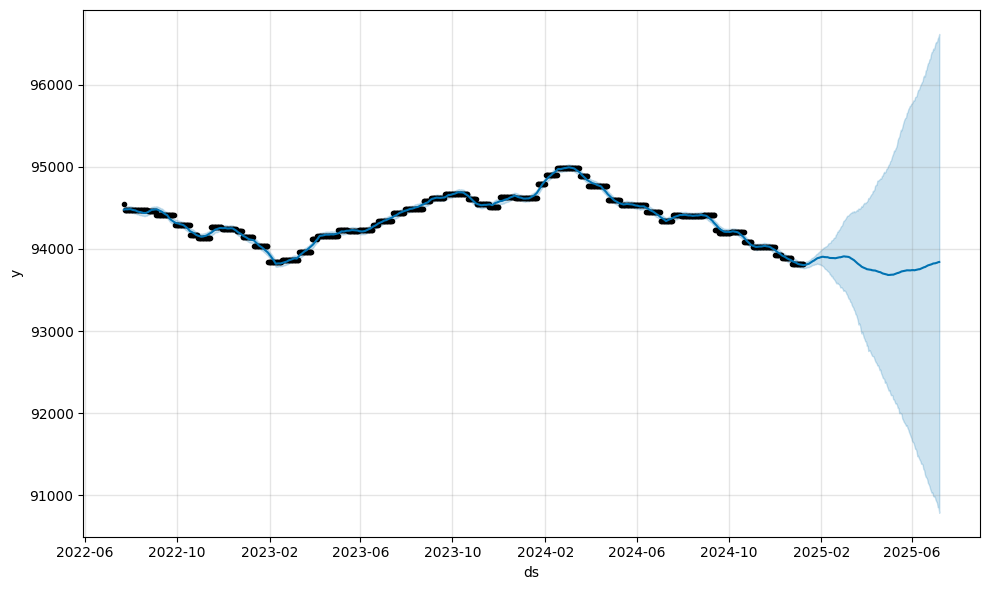

In [40]:
df_btc['ds'] = pd.to_datetime(df_btc['ds'])  
last_date = df_btc['ds'].max()
one_year_ago = last_date - timedelta(days=900)
df_btc_one_year = df_btc[df_btc['ds'] >= one_year_ago]

daily_model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')
daily_model.fit(df_btc_one_year)

future_dates = daily_model.make_future_dataframe(periods=180, freq='D')  # 6 months = 180 days

forecast = daily_model.predict(future_dates)

fig = daily_model.plot(forecast)


In [41]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
import math

def preprocess_data(file_path, coin_name):
    df = pd.read_csv(file_path)

    df_new = df[df["symbol"] == coin_name]
    df_new = df_new.drop(columns=["symbol", "datetime"])
    df_new = df_new.reset_index(drop=True)
    df_new = df_new.rename(columns={'date': 'ds', 'price': 'y'})
    
    # Set constant time '12:00:00' for all dates
    df_new['ds'] = pd.to_datetime(df_new['ds']).dt.date.astype(str) + " 12:00:00"
    df_new['ds'] = pd.to_datetime(df_new['ds'])  # Convert back to datetime
    
    # Sort the data by 'ds'
    df_new = df_new.sort_values(by='ds').reset_index(drop=True)

    # Add percentage change as the target variable
    df_new['y_pct_change'] = df_new['y'].pct_change().fillna(0)

    # Add lagged features
    df_new['lag_1'] = df_new['y'].shift(1).fillna(df_new['y'].iloc[0])
    df_new['rolling_mean_3'] = df_new['y'].rolling(window=3).mean().fillna(df_new['y'].iloc[0])

    return df_new

# LightGBM Model
def LGBM_Model(df, horizon=900):
    # Ensure 'ds' is the index
    df = df.set_index('ds')

    # Use percentage change as the target variable
    X = df.drop(['y', 'y_pct_change'], axis=1)
    y = df['y_pct_change']

    # Train-Test Split
    X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

    # LightGBM Modeling
    lgbm = LGBMRegressor(
        random_state=42,
        n_estimators=1000,  # Increase the number of trees
        learning_rate=0.01,  # Lower learning rate for small changes
        num_leaves=31,  # Adjust tree complexity
        min_child_weight=0.1  # Focus on small changes
    )
    lgbm.fit(X_train, y_train)
    lgbm_predictions = lgbm.predict(X_test)

    # Convert predictions to pandas Series with the same index as y_test
    lgbm_predictions_series = pd.Series(lgbm_predictions, index=y_test.index)

    # Rescale predictions back to original scale
    actual_prices = df['y'].iloc[-horizon:]
    predicted_prices = actual_prices.shift(1) * (1 + lgbm_predictions_series)
    predicted_prices = predicted_prices.fillna(actual_prices.iloc[0])

    # Evaluation Metrics
    lgbm_mae = np.round(mean_absolute_error(actual_prices, predicted_prices), 3)
    lgbm_mape = np.round(mean_absolute_percentage_error(actual_prices, predicted_prices), 3)
    lgbm_mse = np.round(mean_squared_error(actual_prices, predicted_prices), 3)
    lgbm_rmse = np.round(math.sqrt(lgbm_mse), 3)

    print(f"MAE: {lgbm_mae}")
    print(f"MAPE: {lgbm_mape}")
    print(f"MSE: {lgbm_mse}")
    print(f"RMSE: {lgbm_rmse}")

    # Plotting Actual vs Predicted
    fig = plt.figure(figsize=(16, 6))
    plt.title('Actual vs LightGBM Predictions', fontsize=20)
    plt.plot(actual_prices, color='red', label='Actual Values')
    plt.plot(predicted_prices, color='green', label='LGBM Predictions')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid()
    plt.xticks(rotation=45)

    plt.show()

    return lgbm_mae, lgbm_mape, lgbm_mse, lgbm_rmse, fig


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 141, number of used features: 13
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

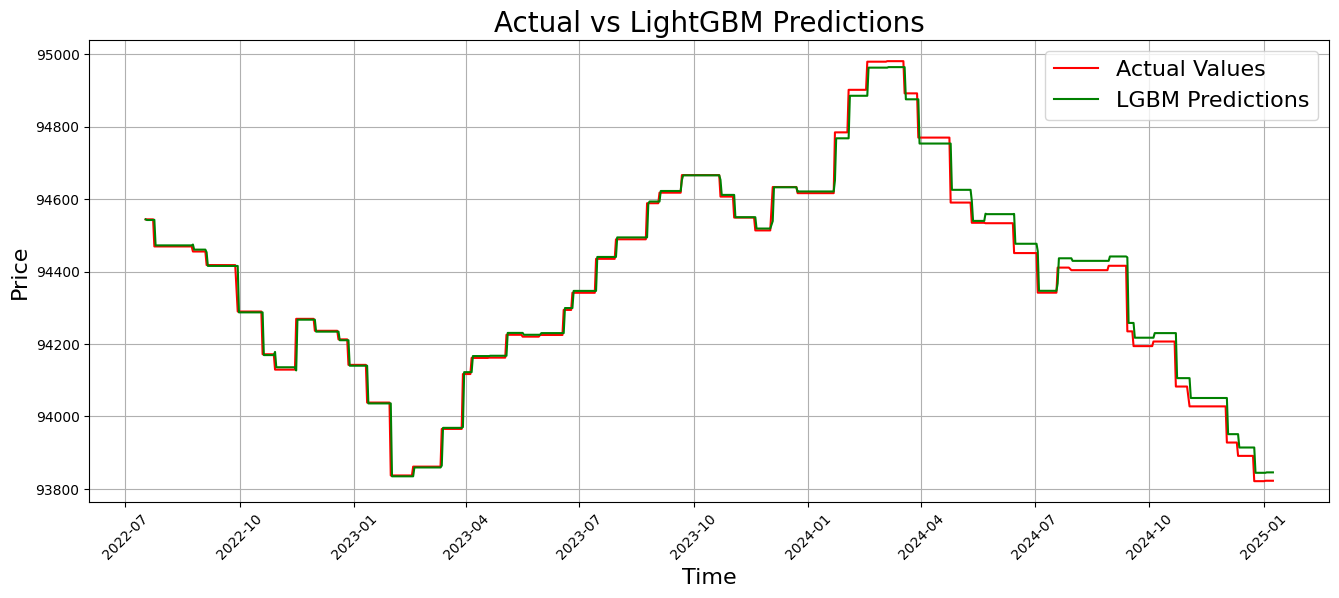

Evaluation Metrics: (14.047, 0.0, 649.615, 25.488, <Figure size 1600x600 with 1 Axes>)


In [42]:
file_path = "/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/artifacts/df_last_year_20250109.csv"
df_btc = preprocess_data(file_path, "BTC")
lgbm_metrics = LGBM_Model(df_btc)

print("Evaluation Metrics:", lgbm_metrics)

In [43]:
from xgboost import XGBRegressor

def XGB_Model(df, horizon=800):
    # Ensure 'ds' is the index
    df = df.set_index('ds')

    # Use percentage change as the target variable
    X = df.drop(['y', 'y_pct_change'], axis=1)
    y = df['y_pct_change']

    # Train-Test Split
    X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

    # XGBoost Modeling
    xgb = XGBRegressor(
        random_state=42,
        n_estimators=1000,  # Increase the number of trees
        learning_rate=0.01,  # Lower learning rate for small changes
        max_depth=6,  # Adjust tree depth
        subsample=0.8,  # Use a fraction of samples
        colsample_bytree=0.8  # Use a fraction of features
    )
    xgb.fit(X_train, y_train)
    xgb_predictions = xgb.predict(X_test)

    # Convert predictions to pandas Series with the same index as y_test
    xgb_predictions_series = pd.Series(xgb_predictions, index=y_test.index)

    # Rescale predictions back to original scale
    actual_prices = df['y'].iloc[-horizon:]
    predicted_prices = actual_prices.shift(1) * (1 + xgb_predictions_series)
    predicted_prices = predicted_prices.fillna(actual_prices.iloc[0])

    # Evaluation Metrics
    xgb_mae = np.round(mean_absolute_error(actual_prices, predicted_prices), 3)
    xgb_mape = np.round(mean_absolute_percentage_error(actual_prices, predicted_prices), 3)
    xgb_mse = np.round(mean_squared_error(actual_prices, predicted_prices), 3)
    xgb_rmse = np.round(math.sqrt(xgb_mse), 3)

    print(f"MAE: {xgb_mae}")
    print(f"MAPE: {xgb_mape}")
    print(f"MSE: {xgb_mse}")
    print(f"RMSE: {xgb_rmse}")

    # Plotting Actual vs Predicted
    fig = plt.figure(figsize=(16, 6))
    plt.title('Actual vs XGBoost Predictions', fontsize=20)
    plt.plot(actual_prices, color='red', label='Actual Values')
    plt.plot(predicted_prices, color='green', label='XGB Predictions')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid()
    plt.xticks(rotation=45)

    plt.show()

    return xgb_mae, xgb_mape, xgb_mse, xgb_rmse, fig


MAE: 5.482
MAPE: 0.0
MSE: 467.142
RMSE: 21.613


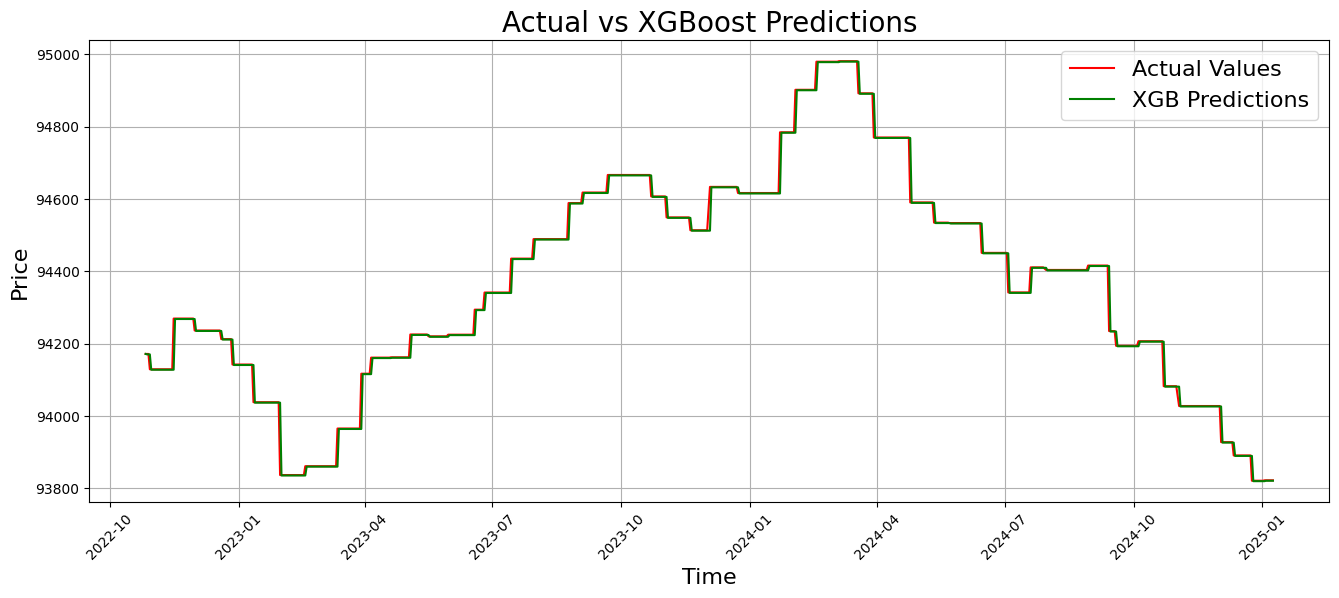

(5.482, 0.0, 467.142, 21.613, <Figure size 1600x600 with 1 Axes>)

In [44]:
XGB_Model(df_btc)

In [45]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math

def XGB_Model_Forecast(df, horizon=800, forecast_horizon=180):
    """
    Train the XGBoost model and forecast for the next `forecast_horizon` steps.

    Parameters:
    - df: DataFrame containing historical data with 'ds' as dates, 'y' as prices, and 'y_pct_change' as target.
    - horizon: Number of steps for evaluation.
    - forecast_horizon: Number of future steps to forecast.

    Returns:
    - xgb_mae, xgb_mape, xgb_mse, xgb_rmse, fig: Evaluation metrics and plot of actual vs predicted values.
    - forecast_prices: Forecasted prices for the next `forecast_horizon` steps.
    """
    # Ensure 'ds' is the index
    df = df.set_index('ds')

    # Use percentage change as the target variable
    X = df.drop(['y', 'y_pct_change'], axis=1)
    y = df['y_pct_change']

    # Train-Test Split
    X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

    # XGBoost Modeling
    xgb = XGBRegressor(
        random_state=42,
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8
    )
    xgb.fit(X_train, y_train)
    xgb_predictions = xgb.predict(X_test)

    # Convert predictions to pandas Series with the same index as y_test
    xgb_predictions_series = pd.Series(xgb_predictions, index=y_test.index)

    # Rescale predictions back to original scale
    actual_prices = df['y'].iloc[-horizon:]
    predicted_prices = actual_prices.shift(1) * (1 + xgb_predictions_series)
    predicted_prices = predicted_prices.fillna(actual_prices.iloc[0])

    # Evaluation Metrics
    xgb_mae = np.round(mean_absolute_error(actual_prices, predicted_prices), 3)
    xgb_mape = np.round(mean_absolute_percentage_error(actual_prices, predicted_prices), 3)
    xgb_mse = np.round(mean_squared_error(actual_prices, predicted_prices), 3)
    xgb_rmse = np.round(math.sqrt(xgb_mse), 3)

    print(f"MAE: {xgb_mae}")
    print(f"MAPE: {xgb_mape}")
    print(f"MSE: {xgb_mse}")
    print(f"RMSE: {xgb_rmse}")

    # Forecasting for the next `forecast_horizon` steps
    last_features = X.iloc[-1, :].values.reshape(1, -1)  # Start from the last available features
    forecast_prices = []
    last_price = actual_prices.iloc[-1]

    for step in range(forecast_horizon):
        next_pct_change = xgb.predict(last_features)[0]  # Predict the next percentage change
        next_price = last_price * (1 + next_pct_change)  # Calculate the next price
        forecast_prices.append(next_price)

        # Update `last_features` with the predicted percentage change
        next_features = np.append(last_features[0, 1:], [next_pct_change])  # Shift features
        last_features = next_features.reshape(1, -1)
        last_price = next_price

    forecast_dates = pd.date_range(start=actual_prices.index[-1], periods=forecast_horizon + 1, freq='D')[1:]
    forecast_prices = pd.Series(forecast_prices, index=forecast_dates)

    # Plotting Actual vs Predicted
    fig = plt.figure(figsize=(16, 6))
    plt.title('Actual, XGBoost Predictions, and Forecasts', fontsize=20)
    plt.plot(actual_prices, color='red', label='Actual Values')
    plt.plot(predicted_prices, color='green', label='XGB Predictions')
    plt.plot(forecast_prices, color='blue', label='Forecast Prices')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid()
    plt.xticks(rotation=45)

    plt.show()

    return xgb_mae, xgb_mape, xgb_mse, xgb_rmse, fig, forecast_prices


MAE: 5.482
MAPE: 0.0
MSE: 467.142
RMSE: 21.613


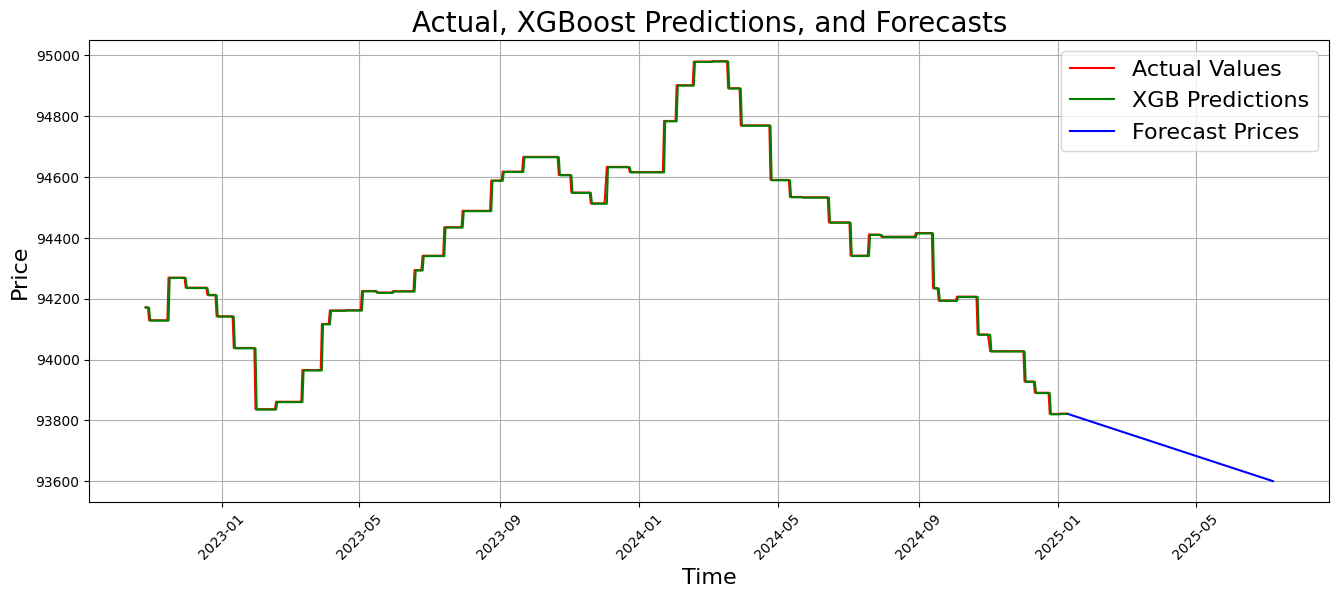

2025-01-09 12:00:00    93821.240459
2025-01-10 12:00:00    93820.005827
2025-01-11 12:00:00    93818.771212
2025-01-12 12:00:00    93817.536614
2025-01-13 12:00:00    93816.302031
                           ...     
2025-07-03 12:00:00    93605.427171
2025-07-04 12:00:00    93604.195380
2025-07-05 12:00:00    93602.963605
2025-07-06 12:00:00    93601.731846
2025-07-07 12:00:00    93600.500103
Freq: D, Length: 180, dtype: float64


In [46]:
# Assuming `df_btc` is your DataFrame with columns 'ds', 'y', and 'y_pct_change'.
xgb_mae, xgb_mape, xgb_mse, xgb_rmse, fig, forecast_prices = XGB_Model_Forecast(df_btc, horizon=800, forecast_horizon=180)

# Print forecasted prices
print(forecast_prices)


In [21]:
def Prophet_Features(df):
    df.reset_index(inplace=True)
    pd.to_datetime(df["ds"])
    prophet_model = Prophet(
                        growth='linear',
                        seasonality_mode='additive',
                        interval_width=0.95,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=False
                    )
    prophet_model.fit(df)
    prophet_results = prophet_model.predict(df.drop('y', axis=1))
        
    return prophet_results

In [22]:
Prophet_Features(df_btc)

10:12:06 - cmdstanpy - INFO - Chain [1] start processing
10:12:07 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-02-24 12:00:00,94439.606948,94349.412583,94530.205475,94439.606948,94439.606948,0.981695,0.981695,0.981695,1.546759,1.546759,1.546759,-0.565064,-0.565064,-0.565064,0.0,0.0,0.0,94440.588643
1,2022-02-25 12:00:00,94442.595641,94355.493928,94526.529206,94442.595641,94442.595641,0.847365,0.847365,0.847365,1.546759,1.546759,1.546759,-0.699394,-0.699394,-0.699394,0.0,0.0,0.0,94443.443007
2,2022-02-26 12:00:00,94445.584335,94352.280509,94530.367154,94445.584335,94445.584335,1.241407,1.241407,1.241407,1.546759,1.546759,1.546759,-0.305353,-0.305353,-0.305353,0.0,0.0,0.0,94446.825741
3,2022-02-27 12:00:00,94448.573028,94364.008406,94542.694154,94448.573028,94448.573028,3.199205,3.199205,3.199205,1.546759,1.546759,1.546759,1.652445,1.652445,1.652445,0.0,0.0,0.0,94451.772232
4,2022-02-28 12:00:00,94451.561721,94358.812708,94548.672596,94451.561721,94451.561721,2.010253,2.010253,2.010253,1.546759,1.546759,1.546759,0.463493,0.463493,0.463493,0.0,0.0,0.0,94453.571974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,2025-01-04 12:00:00,93872.993605,93786.660999,93960.816656,93872.993605,93872.993605,1.241407,1.241407,1.241407,1.546759,1.546759,1.546759,-0.305353,-0.305353,-0.305353,0.0,0.0,0.0,93874.235011
1037,2025-01-05 12:00:00,93869.759166,93786.230506,93966.738326,93869.759166,93869.759166,3.199205,3.199205,3.199205,1.546759,1.546759,1.546759,1.652445,1.652445,1.652445,0.0,0.0,0.0,93872.958370
1038,2025-01-06 12:00:00,93866.524727,93785.592121,93955.722636,93866.524727,93866.524727,2.010253,2.010253,2.010253,1.546759,1.546759,1.546759,0.463493,0.463493,0.463493,0.0,0.0,0.0,93868.534980
1039,2025-01-07 12:00:00,93863.290289,93776.642547,93960.270197,93863.290289,93863.290289,2.536626,2.536626,2.536626,1.546759,1.546759,1.546759,0.989867,0.989867,0.989867,0.0,0.0,0.0,93865.826915


In [ ]:
df_btc.set_index('ds', inplace=True)
df_btc.head()

,level_0,index,y,volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,circulating_supply,total_supply,y_pct_change,lag_1,rolling_mean_3
ds,,,,,,,,,,,,,,,,,,,
2022-02-24 12:00:00,0,1970-01-01 00:00:00.000000000,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0,0.0,94469.95129,94469.95129
2022-02-25 12:00:00,1,1970-01-01 00:00:00.000000001,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0,0.0,94469.95129,94469.95129
2022-02-26 12:00:00,2,1970-01-01 00:00:00.000000002,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0,0.0,94469.95129,94469.95129
2022-02-27 12:00:00,3,1970-01-01 00:00:00.000000003,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0,0.0,94469.95129,94469.95129
2022-02-28 12:00:00,4,1970-01-01 00:00:00.000000004,94469.95129,6.616604e+10,20.0372,-0.083482,-2.323822,0.338016,-2.981795,23.969996,58.575804,1.871205e+12,56.6557,1.983869e+12,19807409.0,19807409.0,0.0,94469.95129,94469.95129


In [25]:
def Multi_Seasonal_decompose(df):
    from statsmodels.tsa.seasonal import MSTL
    import matplotlib.pyplot as plt

    mstl = MSTL(df["y"], periods=[7, 30, 365])  # Weekly, monthly, yearly seasonality
    mstl_results = mstl.fit()

    # Assign seasonal components to separate columns
    df["Weekly_Seasonality"] = mstl_results.seasonal[:, 0]  # First seasonal component (weekly)
    df["Monthly_Seasonality"] = mstl_results.seasonal[:, 1]  # Second seasonal component (monthly)
    df["Yearly_Seasonality"] = mstl_results.seasonal[:, 2]  # Third seasonal component (yearly)

    # Plot the decomposition
    mstl_results.plot()
    plt.show()

# Example usage with df_btc
Multi_Seasonal_decompose(df_btc)


InvalidIndexError: (slice(None, None, None), 0)

In [10]:
class TimeSeriesModeling:
    def __init__(self):
        pass
    
    @staticmethod
    def Multi_Seasonal_decompose_Weekly(df):
        mstl = MSTL(df["y"], periods=[7, 30, 365])
        mstl_results = mstl.fit()
        df[["Hourly_Seasonlity","Weekly_Seasonality"]] = mstl_results.seasonal
        return df

    @staticmethod
    def Triple_ETS(df):
        df['Triple_Multiplicative_ETS'] = ExponentialSmoothing(df['y'],trend='mul',seasonal='mul',seasonal_periods=24*7).fit().fittedvalues
        df['Triple_Additive_ETS'] = ExponentialSmoothing(df['y'],trend='add',seasonal='add',seasonal_periods=24*7).fit().fittedvalues
        df.drop(columns=['index'], inplace=True)
        return df

    @staticmethod
    def Prophet_Features(df):
        df.reset_index(inplace=True)
        pd.to_datetime(df["ds"])
        prophet_model = Prophet(
                        growth='linear',
                        seasonality_mode='additive',
                        interval_width=0.95,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=False
                    )
        prophet_model.fit(df)
        prophet_results = prophet_model.predict(df.drop('y', axis=1))
        
        return prophet_results
    
    @staticmethod
    def Merging_DFs(df1, df2):
        
        df1['ds'] = df1['ds'].astype(str)
        df2['ds'] = df2['ds'].astype(str)
        featured_df = pd.merge(df1, df2, how='left', on='ds')
        featured_df.set_index('ds', inplace=True)
        # featured_df.reset_index(inplace=True)
        
        return featured_df
    
    @staticmethod
    def XGB_Model(df, horizon):
        horizon = horizon
        # df.set_index('ds')
        df.index = pd.to_datetime(df.index)
        X = df.drop('y', axis=1)
        y = df['y']

        # Training and Testing
        X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
        y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
        # Modeling with XGBoost
        xgb = XGBRegressor(random_state=42)
        xgb.fit(X_train, y_train)
        xgb_predictions = xgb.predict(X_test)
        # Evaluation of XGBoost
        xgb_mae = np.round(mean_absolute_error(y_test, xgb_predictions), 3)    
        xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)
        xgb_mse = mean_squared_error(y_test, xgb_predictions)
        xgb_rmse = math.sqrt(xgb_mse)
        
        # Figure Plotting
        fig = plt.figure(figsize=(16,6))
        plt.title(f'Actual vs XGBoost', fontsize=20)
        plt.plot(y_test, color='red')
        plt.plot(pd.Series(xgb_predictions, index=y_test.index), color='green')
        plt.xlabel('Time', fontsize=16)
        plt.ylabel('Number of Counts', fontsize=16)
        plt.legend(labels=['Actual Values', 'XGB Predictions'], fontsize=16)
        plt.grid()
        plt.xticks(pd.date_range(start=y_test.index[0], end=y_test.index[-1], freq='W'), rotation=45) 
        plt.show()
        print(f"Mean Absolute Error: {xgb_mae} \nMAPE: {xgb_mape} \nMean Squared Error: {xgb_mse} \nRoot Mean Squared Error: {xgb_rmse}")

        
    
    @staticmethod
    def LGBM_Model(df, horizon):
        horizon = horizon
        # df.set_index('ds')
        df.index = pd.to_datetime(df.index)  # Convert index to datetime if not already
        X = df.drop('y', axis=1)
        y = df['y']

        # Training and Testing
        X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
        y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

        # Modeling with LGBM
        lgbm = LGBMRegressor(random_state=42)
        lgbm.fit(X_train, y_train)
        lgbm_predictions = lgbm.predict(X_test)
        # Evaluation of LGBM
        lgbm_mae = np.round(mean_absolute_error(y_test, lgbm_predictions), 3)    
        lgbm_mape = mean_absolute_percentage_error(y_test, lgbm_predictions)
        lgbm_mse = mean_squared_error(y_test, lgbm_predictions)
        lgbm_rmse = math.sqrt(lgbm_mse)

        # Figure Plotting
        fig = plt.figure(figsize=(16,6))
        plt.title(f'Actual vs LightGBM', fontsize=20)
        plt.plot(y_test, color='red')
        plt.plot(pd.Series(lgbm_predictions, index=y_test.index), color='green')
        plt.xlabel('Time', fontsize=16)
        plt.ylabel('Number of Counts', fontsize=16)
        plt.legend(labels=['Actual Values', 'LGBM Predictions'], fontsize=16)
        plt.grid()
        plt.xticks(pd.date_range(start=y_test.index[0], end=y_test.index[-1], freq='W'), rotation=45) 
        plt.show()
        
        print(f"Mean Absolute Error: {lgbm_mae} \nMAPE: {lgbm_mape} \nMean Squared Error: {lgbm_mse} \nRoot Mean Squared Error: {lgbm_rmse}")
        
        
     

In [ ]:
Forecasting = TimeSeriesModeling()
Prophet_Features = Forecasting.Prophet_Features(df)
Prophet_Features.head()


In [ ]:
ETS = Forecasting.Triple_ETS(df)
ETS.head()

In [13]:
MSTL = Forecasting.Multi_Seasonal_decompose_Weekly(ETS)

In [ ]:
MSTL

In [ ]:
Final_DF = Forecasting.Merging_DFs(MSTL,Prophet_Features)
Final_DF

In [ ]:
Forecasting.LGBM_Model(Final_DF, 24)

In [ ]:
Forecasting.XGB_Model(Final_DF,24)

In [ ]:
df = pd.read_csv("visitors_count_data.csv")
df.head()

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult
import math
import seaborn as sns
import matplotlib.dates as mdates
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

class TimeSeriesModeling:
    def __init__(self, df, target_column):
        self.df = df
        self.target_column = target_column
        self.preprocess_data()
    
    def preprocess_data(self):
        # Perform preprocessing steps
        self.df.drop(columns=["Holiday Name", "Date"], inplace=True)
        self.df.set_index("ds", inplace=True)
        # Rename target column
        self.df.rename(columns={self.target_column: "y"}, inplace=True)
    
    def multi_seasonal_decompose_weekly(self):
        mstl = MSTL(self.df["y"], periods=[13, 13 * 7])
        mstl_results = mstl.fit()
        self.df[["Hourly_Seasonlity", "Weekly_Seasonality"]] = mstl_results.seasonal
    
    def triple_ets(self):
        self.df['Triple_Multiplicative_ETS'] = ExponentialSmoothing(self.df['y'], trend='mul', seasonal='mul', seasonal_periods=24*7).fit().fittedvalues
        self.df['Triple_Additive_ETS'] = ExponentialSmoothing(self.df['y'], trend='add', seasonal='add', seasonal_periods=24*7).fit().fittedvalues
        # self.df.drop(columns=['index'], inplace=True)
    
    def prophet_features(self):
        self.df.reset_index(inplace=True)
        pd.to_datetime(self.df["ds"])
        prophet_model = Prophet(
                        growth='linear',
                        seasonality_mode='additive',
                        interval_width=0.95,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=False
                    )
        prophet_model.fit(self.df)
        prophet_results = prophet_model.predict(self.df.drop('y', axis=1))
        return prophet_results
    
    def merging_dfs(self, df2):
        self.df['ds'] = self.df['ds'].astype(str)
        df2['ds'] = df2['ds'].astype(str)
        featured_df = pd.merge(self.df, df2, how='left', on='ds')
        featured_df.set_index('ds', inplace=True)
        # featured_df.drop(columns=["index"], inplace=True)
        return featured_df
    
    def xgb_model(self, df, horizon):
        horizon = horizon
        df.index = pd.to_datetime(df.index)
        X = df.drop('y', axis=1)
        y = df['y']

        # Training and Testing
        X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
        y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

        # Modeling with XGBoost
        xgb = XGBRegressor(random_state=42)
        xgb.fit(X_train, y_train)
        xgb_predictions = xgb.predict(X_test)
        # Evaluation of XGBoost
        xgb_mae = np.round(mean_absolute_error(y_test, xgb_predictions), 3)
        xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)
        xgb_mse = mean_squared_error(y_test, xgb_predictions)
        xgb_rmse = math.sqrt(xgb_mse)

        # Figure Plotting
        fig = plt.figure(figsize=(16, 6))
        plt.title(f'Actual vs XGBoost', fontsize=20)
        plt.plot(y_test, color='red')
        plt.plot(pd.Series(xgb_predictions, index=y_test.index), color='green')
        plt.xlabel('Time', fontsize=16)
        plt.ylabel('Number of Counts', fontsize=16)
        plt.legend(labels=['Actual Values', 'XGB Predictions'], fontsize=16)
        plt.grid()
        plt.xticks(pd.date_range(start=y_test.index[0], end=y_test.index[-1], freq='W'), rotation=45)
        plt.show()
        print(f"Mean Absolute Error: {xgb_mae} \nMAPE: {xgb_mape} \nMean Squared Error: {xgb_mse} \nRoot Mean Squared Error: {xgb_rmse}")

    def lgbm_model(self, df, horizon):
        horizon = horizon
        df.index = pd.to_datetime(df.index)  # Convert index to datetime if not already
        X = df.drop('y', axis=1)
        y = df['y']

        # Training and Testing
        X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
        y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

        # Modeling with LGBM
        lgbm = LGBMRegressor(random_state=42)
        lgbm.fit(X_train, y_train)
        lgbm_predictions = lgbm.predict(X_test)
        # Evaluation of LGBM
        lgbm_mae = np.round(mean_absolute_error(y_test, lgbm_predictions), 3)
        lgbm_mape = mean_absolute_percentage_error(y_test, lgbm_predictions)
        lgbm_mse = mean_squared_error(y_test, lgbm_predictions)
        lgbm_rmse = math.sqrt(lgbm_mse)

        # Figure Plotting
        fig = plt.figure(figsize=(16, 6))
        plt.title(f'Actual vs LightGBM', fontsize=20)
        plt.plot(y_test, color='red')
        plt.plot(pd.Series(lgbm_predictions, index=y_test.index), color='green')
        plt.xlabel('Time', fontsize=16)
        plt.ylabel('Number of Counts', fontsize=16)
        plt.legend(labels=['Actual Values', 'LGBM Predictions'], fontsize=16)
        plt.grid()
        plt.xticks(pd.date_range(start=y_test.index[0], end=y_test.index[-1], freq='W'), rotation=45)
        plt.show()

        print(f"Mean Absolute Error: {lgbm_mae} \nMAPE: {lgbm_mape} \nMean Squared Error: {lgbm_mse} \nRoot Mean Squared Error: {lgbm_rmse}")


In [ ]:
df = pd.read_csv("visitors_count_data.csv")
model = TimeSeriesModeling(df, "y")
df.head()


In [ ]:
model.lgbm_model(df, horizon=24)

In [91]:
df1 = model.multi_seasonal_decompose_weekly()

In [ ]:
df.head()

In [93]:
model.triple_ets()


In [ ]:
df.head()

In [ ]:
prophet_df = model.prophet_features()

In [96]:
df = model.merging_dfs(prophet_df)

In [ ]:
df.head()

In [ ]:
type(df.index)

In [ ]:
model.lgbm_model(df, horizon = 24*7)

In [ ]:
model.xgb_model(df, horizon = 24*7)